In [30]:
import numpy as np
import matplotlib.pyplot as plt

from jax_sysid.models import LinearModel
from jax_sysid.utils import compute_scores


In [31]:
# True system (this is our "ground truth")
A_true = np.array([[0.9]])   # 1x1
B_true = np.array([[0.1]])   # 1x1
C_true = np.array([[1.0]])   # 1x1
D_true = np.array([[0.0]])   # 1x1

nx, nu, ny = 1, 1, 1


C:\Users\onyer\AppData\Local\Temp\ipykernel_9956\2133333449.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k+1] = A_true @ np.array([x[k]]) + B_true @ np.array([u[k]])
C:\Users\onyer\AppData\Local\Temp\ipykernel_9956\2133333449.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k]   = C_true @ np.array([x[k]]) + D_true @ np.array([u[k]])
C:\Users\onyer\AppData\Local\Temp\ipykernel_9956\2133333449.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[-1

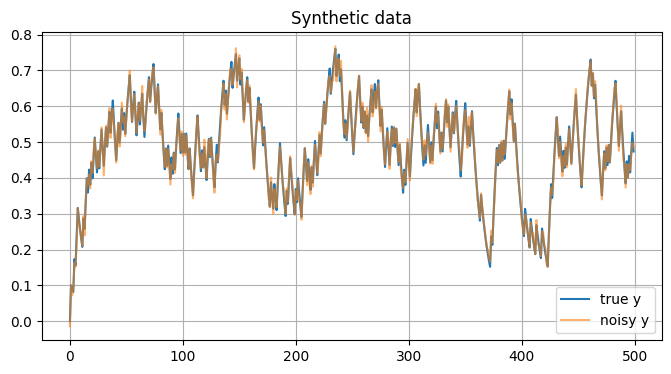

In [32]:
# Simulation settings
N = 500          # number of samples
dt = 1.0         # sample time (not used explicitly here)

# Input: random steps (0 or 1)
u = (np.random.rand(N) > 0.5).astype(float)

# Simulate true system
x = np.zeros(N)
y = np.zeros(N)

for k in range(N-1):
    x[k+1] = A_true @ np.array([x[k]]) + B_true @ np.array([u[k]])
    y[k]   = C_true @ np.array([x[k]]) + D_true @ np.array([u[k]])

# Last output
y[-1] = C_true @ np.array([x[-1]]) + D_true @ np.array([u[-1]])

# Add small noise to outputs
noise_std = 0.01
y_noisy = y + noise_std*np.random.randn(N)

# Reshape for jax-sysid: (N,ny), (N,nu)
U = u.reshape(-1, 1)
Y = y_noisy.reshape(-1, 1)

plt.figure(figsize=(8,4))
plt.plot(y, label="true y")
plt.plot(y_noisy, label="noisy y", alpha=0.6)
plt.legend(); plt.grid(True); plt.title("Synthetic data"); plt.show()


In [33]:
# Create a LinearModel with the correct state/input/output dimensions
model = LinearModel(nx=nx, ny=ny, nu=nu)

# Define the loss (L2 on theta and initial state)
model.loss(rho_x0=1e-3, rho_th=1e-2)

# Choose optimizer settings
model.optimization(lbfgs_epochs=500)

# Fit the model to data
model.fit(Y, U)

# Predict on the training data
Yhat, Xhat = model.predict(model.x0, U)

# Compute R² score
R2_train, _, msg = compute_scores(Y, Yhat, None, None, fit='R2')
print(msg)


Solving NLP with L-BFGS (4 optimization variables) ...
L-BFGS-B done in 47 iterations.
R2 score:  training =  99.3314


In [34]:
A_id, B_id, C_id, D_id = model.ssdata()

print("True A:", A_true)
print("ID   A:", A_id)

print("True B:", B_true)
print("ID   B:", B_id)

print("True C:", C_true)
print("ID   C:", C_id)

print("True D:", D_true)
print("ID   D:", D_id)


True A: [[0.9]]
ID   A: [[0.90161232]]
True B: [[0.1]]
ID   B: [[0.31293018]]
True C: [[1.]]
ID   C: [[0.31293474]]
True D: [[0.]]
ID   D: [[0.]]


## Nonlinear

In [35]:
import jax
import jax.numpy as jnp
from jax_sysid.models import Model

dt = 0.1
nx, ny, nu = 1, 1, 1

# We will parametrize the dynamics with theta = [a, b], where
# x_{k+1} = x_k + dt * (a*x_k + b*x_k^3 + u_k) 

def state_fcn(x, u, params):
    theta = params[0]          # theta is (2,)
    a, b = theta[0], theta[1]
    xdot = a*x + b*(x**3) + u[0]
    return x + dt*xdot

def output_fcn(x, u, params):
    # y = x
    return jnp.array([x])


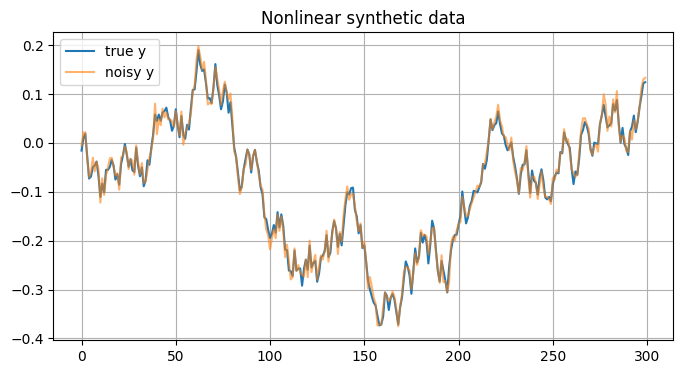

In [36]:
theta_true = jnp.array([-0.1, 0.05])

N = 300
u_nl = (np.random.rand(N) - 0.5).astype(float)  # random inputs in [-0.5,0.5]
# U_nl = u_nl.reshape(-1,1)
U_nl = u_nl

x = 0.0
y_nl = np.zeros(N)

for k in range(N):
    # simulate with the true theta using the same formula as state_fcn
    xdot = float(theta_true[0])*x + float(theta_true[1])*(x**3) + u_nl[k]
    x = x + dt*xdot
    y_nl[k] = x

# Add noise
y_nl_noisy = y_nl + 0.01*np.random.randn(N)
Y_nl = y_nl_noisy
# Y_nl = y_nl_noisy.reshape(-1,1)

plt.figure(figsize=(8,4))
plt.plot(y_nl, label="true y")
plt.plot(y_nl_noisy, label="noisy y", alpha=0.6)
plt.legend(); plt.grid(True); plt.title("Nonlinear synthetic data"); plt.show()


In [37]:
model_nl = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# Initial guess for theta
theta0 = jnp.array([-0.2, 0.1])       # deliberately different
model_nl.init(params=[theta0])

# Loss & optimization settings
model_nl.loss(rho_x0=1e-4, rho_th=1e-4)
model_nl.optimization(adam_epochs=200, lbfgs_epochs=500)

# Fit
model_nl.fit(Y_nl, U_nl)

# Predictions
Yhat_nl, Xhat_nl = model_nl.predict(model_nl.x0, U_nl)

R2_train, _, msg = compute_scores(Y_nl, Yhat_nl, None, None, fit='R2')
print(msg)

print("True theta:", theta_true)
print("ID   theta:", model_nl.params[0])


  0%|                        |

Solving NLP with Adam (3 optimization variables) ...


100%|████████████████████████|
    f =   8.392025, f* =  8.392025, |grad f| =  2.053250, iter = 200


Solving NLP with L-BFGS (3 optimization variables) ...
L-BFGS-B done in 30 iterations.


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (1, 1), (1,).

In [29]:
print(U_nl.shape)

(300,)


## Minimal jax-sysid example

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from jax_sysid.models import LinearModel
from jax_sysid.utils import compute_scores, standard_scale, unscale


In [15]:
# True system (this is like your "ground truth battery" but very tiny)
nx, nu, ny = 2, 1, 1

A_true = np.array([[0.9, 0.1],
                   [-0.2, 0.8]])
B_true = np.array([[0.1],
                   [0.05]])
C_true = np.array([[1.0, 0.0]])  # measure first state
D_true = np.array([[0.0]])

print("A_true =\n", A_true)
print("B_true =\n", B_true)


A_true =
 [[ 0.9  0.1]
 [-0.2  0.8]]
B_true =
 [[0.1 ]
 [0.05]]


In [16]:
# Simulation settings
N = 500        # number of time steps
dt = 0.1       # sampling time
np.random.seed(0)

# Input: random "current" in [-1,1]
U = np.random.uniform(-1.0, 1.0, size=(N, nu))

# Simulate states and outputs
x = np.zeros((nx,))
X = np.zeros((N, nx))
Y = np.zeros((N, ny))

for k in range(N):
    # output
    y = C_true @ x + D_true @ U[k]
    Y[k] = y

    # next state
    x = A_true @ x + B_true[:, 0] * U[k, 0]
    X[k] = x

# Add some measurement noise to outputs
Y_noisy = Y + 0.05 * np.random.randn(N, ny)

print("Shapes: U", U.shape, "Y_noisy", Y_noisy.shape)


Shapes: U (500, 1) Y_noisy (500, 1)


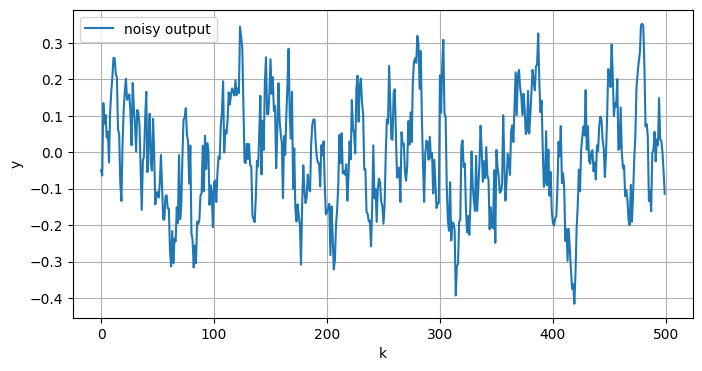

In [17]:
plt.figure(figsize=(8,4))
plt.plot(Y_noisy, label="noisy output")
plt.xlabel("k")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
# 1) Create a LinearModel with correct dimensions
model = LinearModel(nx, ny, nu)

# 2) Define loss (regularization is small here)
model.loss(rho_x0=1e-3, rho_th=1e-3)

# 3) Choose optimization settings
model.optimization(lbfgs_epochs=1000)  # use L-BFGS with at most 1000 evals

# 4) (Optional but good) scale data
Ys, ymean, ygain = standard_scale(Y_noisy)
Us, umean, ugain = standard_scale(U)

# 5) Fit the model
model.fit(Ys, Us)

# 6) Predict on training data
Yshat, Xhat = model.predict(model.x0, Us)
Yhat = unscale(Yshat, ymean, ygain)


Solving NLP with L-BFGS (10 optimization variables) ...
L-BFGS-B done in 191 iterations.


In [19]:
R2_train, _, msg = compute_scores(Y_noisy, Yhat, None, None, fit='R2')
print(msg)


R2 score:  training =  88.8828


In [20]:
A_id, B_id, C_id, D_id = model.ssdata()

print("=== True vs Identified A ===")
print("A_true =\n", A_true)
print("A_id   =\n", np.array(A_id))

print("\n=== True vs Identified B ===")
print("B_true =\n", B_true)
print("B_id   =\n", np.array(B_id))

print("\n=== True vs Identified C ===")
print("C_true =\n", C_true)
print("C_id   =\n", np.array(C_id))

print("\n=== True vs Identified D ===")
print("D_true =\n", D_true)
print("D_id   =\n", np.array(D_id))


=== True vs Identified A ===
A_true =
 [[ 0.9  0.1]
 [-0.2  0.8]]
A_id   =
 [[ 0.8864618  -0.08396825]
 [ 0.25770921  0.79238448]]

=== True vs Identified B ===
B_true =
 [[0.1 ]
 [0.05]]
B_id   =
 [[0.47952141]
 [0.38422932]]

=== True vs Identified C ===
C_true =
 [[1. 0.]]
C_id   =
 [[0.41640867 0.49484229]]

=== True vs Identified D ===
D_true =
 [[0.]]
D_id   =
 [[0.]]


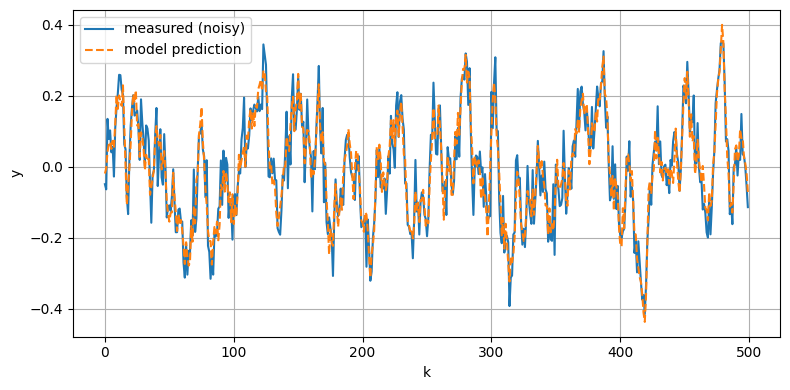

In [21]:
plt.figure(figsize=(8,4))
plt.plot(Y_noisy, label="measured (noisy)")
plt.plot(Yhat, '--', label="model prediction")
plt.xlabel("k")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
